# 時系列データを予測するための訓練(OutputProjectionWrapper非使用)

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

### Where to save the figures

In [22]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [11]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


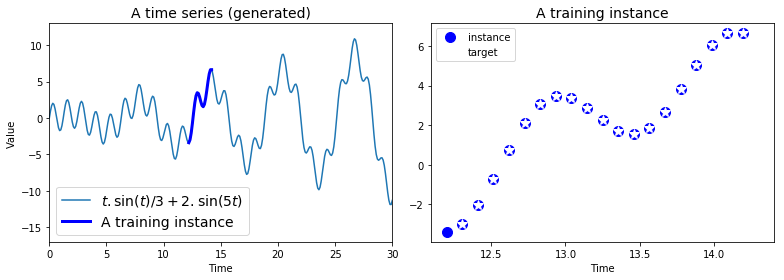

In [23]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1) # t=12.2~　20個分のインスタンス

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [4]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [9]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1
learning_rate = 0.001


X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])#batch_size*n_steps, n_neuronsに形を変える。100ニューロンを全結合
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)#全結合　出力は1個
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])#batch_size, n_steps, n_outputs 元に戻す

In [10]:
loss = tf.reduce_mean(tf.square(outputs - y)) #ブロードキャスト
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [27]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X:X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X:X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    saver.save(sess, "./my_time_series_model")

0 	MSE: 13.798524
100 	MSE: 0.5184861
200 	MSE: 0.18258934
300 	MSE: 0.084822476
400 	MSE: 0.062449113
500 	MSE: 0.060697965
600 	MSE: 0.055861413
700 	MSE: 0.050936103
800 	MSE: 0.05196387
900 	MSE: 0.05027977
1000 	MSE: 0.048902925
1100 	MSE: 0.05085831
1200 	MSE: 0.04179183
1300 	MSE: 0.048203375
1400 	MSE: 0.04349015


In [28]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [29]:
y_pred

array([[[-3.423136 ],
        [-2.4822938],
        [-1.1719801],
        [ 0.6610675],
        [ 2.1233304],
        [ 3.176329 ],
        [ 3.5397706],
        [ 3.3702166],
        [ 2.9088519],
        [ 2.227111 ],
        [ 1.6743507],
        [ 1.4993769],
        [ 1.8663743],
        [ 2.7629812],
        [ 3.8500402],
        [ 5.1123247],
        [ 6.175119 ],
        [ 6.704005 ],
        [ 6.667505 ],
        [ 6.0936575]]], dtype=float32)

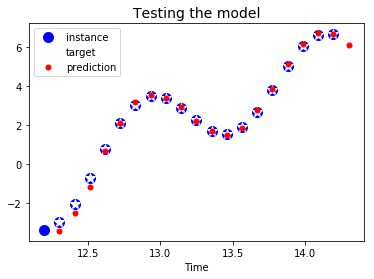

In [32]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0, :,0], "r.", markersize = 10, label="prediction") #3次元になっているので第1,3次元は0, 
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

# Generating a creative new sequence¶

In [54]:
with tf.Session() as sess: 
    saver.restore(sess, "./my_time_series_model")

    sequence = [0.] * n_steps#値が0の20個のインスタンスを生成　
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)#第三引数はn_inputs
         #sequence[-n_steps:]は最後から20個分ののインスタンス
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0]) #outputの最後の出力部分をappend
#追加しながら新しく予測していく

INFO:tensorflow:Restoring parameters from ./my_time_series_model


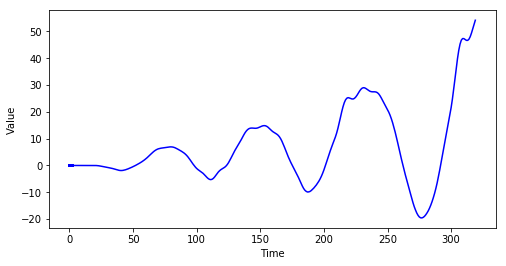

In [55]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./my_time_series_model
Saving figure creative_sequence_plot


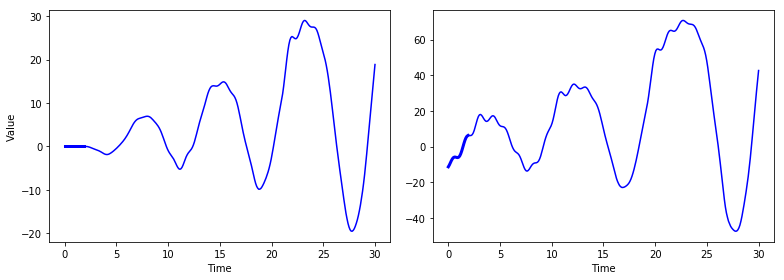

In [56]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
save_fig("creative_sequence_plot")
plt.show()